# Framing the Canon: A Computational Study of Canonicity in Danish Golden Age Paintings (1750-1870)

In [ ]:
# import libraries and modules
import os
import pandas as pd
import numpy as np
import datasets
from datasets import Dataset
from datasets import load_dataset
import json
import pickle
import matplotlib.pyplot as plt 
import sys
sys.path.append(os.path.abspath(".."))

# we get a lot of annoying warnings from sklearn so we suppress them
import warnings
warnings.filterwarnings('ignore')

## Loading data

We work with the SMK data in two different formats:

- df: Pandas DataFrame with SMK metadata on paintings and canonicity

- ds: HuggingFace dataset with same columns as pandas DF, but also a column storing a PIL image of the painting (mainly used here as it's easy to check the painting when it's stored in a ds)

In [ ]:
# load dataset from HuggingFace
ds = load_dataset('chcaa/smk_canon_paintings', split='train') # all the data is in the 'train' split

In [ ]:
# we need to download the images from SMK using the links from the 'image_thumbnail' column:
from src.analyses_utils import add_image_col

ds = add_image_col(ds, 'image_thumbnail')

In [ ]:
# convert to pandas as it's easier to work with
df = ds.to_pandas()

# inspect dataframe
df.head(5)

smk_id period  start_year                                  title  \
0  KMS8884   1835        1835               Parti af torvet i Amalfi   
1  KMS4313   1870        1870           Leonora Christina i fængslet   
2  KMS3880   1800        1800       Jurisprudensen. Allegorisk figur   
3  KMS7591   1800        1800                             Filosofien   
4  KMS3769   1844        1844  Udsigt fra Athenatemplet på Akropolis   

         first_artist           all_artists  num_artists main_type all_types  \
0     Martinus Rørbye     [Martinus Rørbye]            1    Maleri  [Maleri]   
1  Kristian Zahrtmann  [Kristian Zahrtmann]            1    Maleri  [Maleri]   
2  Nicolai Abildgaard  [Nicolai Abildgaard]            1    Maleri  [Maleri]   
3  Nicolai Abildgaard  [Nicolai Abildgaard]            1    Maleri  [Maleri]   
4     Martinus Rørbye     [Martinus Rørbye]            1    Maleri  [Maleri]   

                                     image_thumbnail  ...  \
0  https://iip-thumb.smk.dk/iiif/jp2/tt44ps41w_km...  ...   
1  https://iip-thumb.smk.dk/iiif/jp2/7d278w98c_KM...  ...   
2  https://iip-thumb.smk.dk/iiif/jp2/mw22v869s_KM...  ...   
3  https://iip-thumb.smk.dk/iiif/jp2/3x816q91r_KM...  ...   
4  https://iip-thumb.smk.dk/iiif/jp2/w0892f396_KM...  ...   

  current_location_name literary_reference  \
0               Sal 219               None   
1                  None               None   
2                  None               None   
3                  None               None   
4               Sal 219               None   

                                 object_history_note  \
0                                               None   
1                                               None   
2  [På auktion efter Abildgaards enke solgt til J...   
3                                               None   
4                                               None   

                                   exhibition_venues smk_exhibitions  \
0  [Petit Palais, Sølvgade, Nationalmuseum, Stock...           canon   
1  [Den Hirschsprungske Samling, Ribe Kunstmuseum...           other   
2  [Louvre, Hamburger Kunsthalle, Sølvgade, Nasjo...           canon   
3  [Louvre, Hamburger Kunsthalle, Sølvgade, Det K...           canon   
4                                               None           other   

                               ex_years  exb_canon prod_diff  \
0                    [2020, 2019, 2019]      canon         0   
1  [2006, 2019, 2019, 2020, 2016, 2016]      canon         0   
2  [2008, 2009, 2009, 1992, 1989, 1964]      canon         0   
3              [2008, 2009, 2009, 2001]      canon         0   
4                                  None      other         0   

             prod_notes prod_year  
0  [Værkdatering: 1835]      1835  
1  [Værkdatering: 1870]      1870  
2  [Værkdatering: 1800]      1800  
3  [Værkdatering: 1800]      1800  
4  [Værkdatering: 1844]      1844  

[5 rows x 45 columns]

## Image embeddings

Image embeddings are obtained by running the scripts 'src/smk_embeddings.py' and 'src/greyscale_embeddings.py'. The pretrained model used is EVA-02-CLIP, a multimodal vision transformer architecture. The embeddings are saved as .npy files in the /data folder but can be found as columns in the dataframe. There's two types of embeddings:
- color embeddings: 'as they are' i.e., embeddings extracted from the downloaded image from SMK
- greyscaled embeddings: all images have been converted to greyscale before extracting embeddings from them

### Create subset of colored images only

Throughout the notebook, we'll work with seperate subsets of colored embeddings and greyscaled embeddings

In [74]:
# make subset of colored images only 
color_subset = df.query('rgb == "color"')
color_idx = color_subset.index.tolist()
ds_color = ds.select(color_idx)
color_subset.reset_index(drop=True, inplace=True)

# Analysis

## Synchronic Comparison

We intially inspect groupings in our data with PCA and dendrograms.

Code is adapted from Feldkamp et al. (2024) (https://aclanthology.org/2024.nlp4dh-1.14/)

#### PCA plots per canon category

Text(0.5, 0.95, 'PCA by canon category')

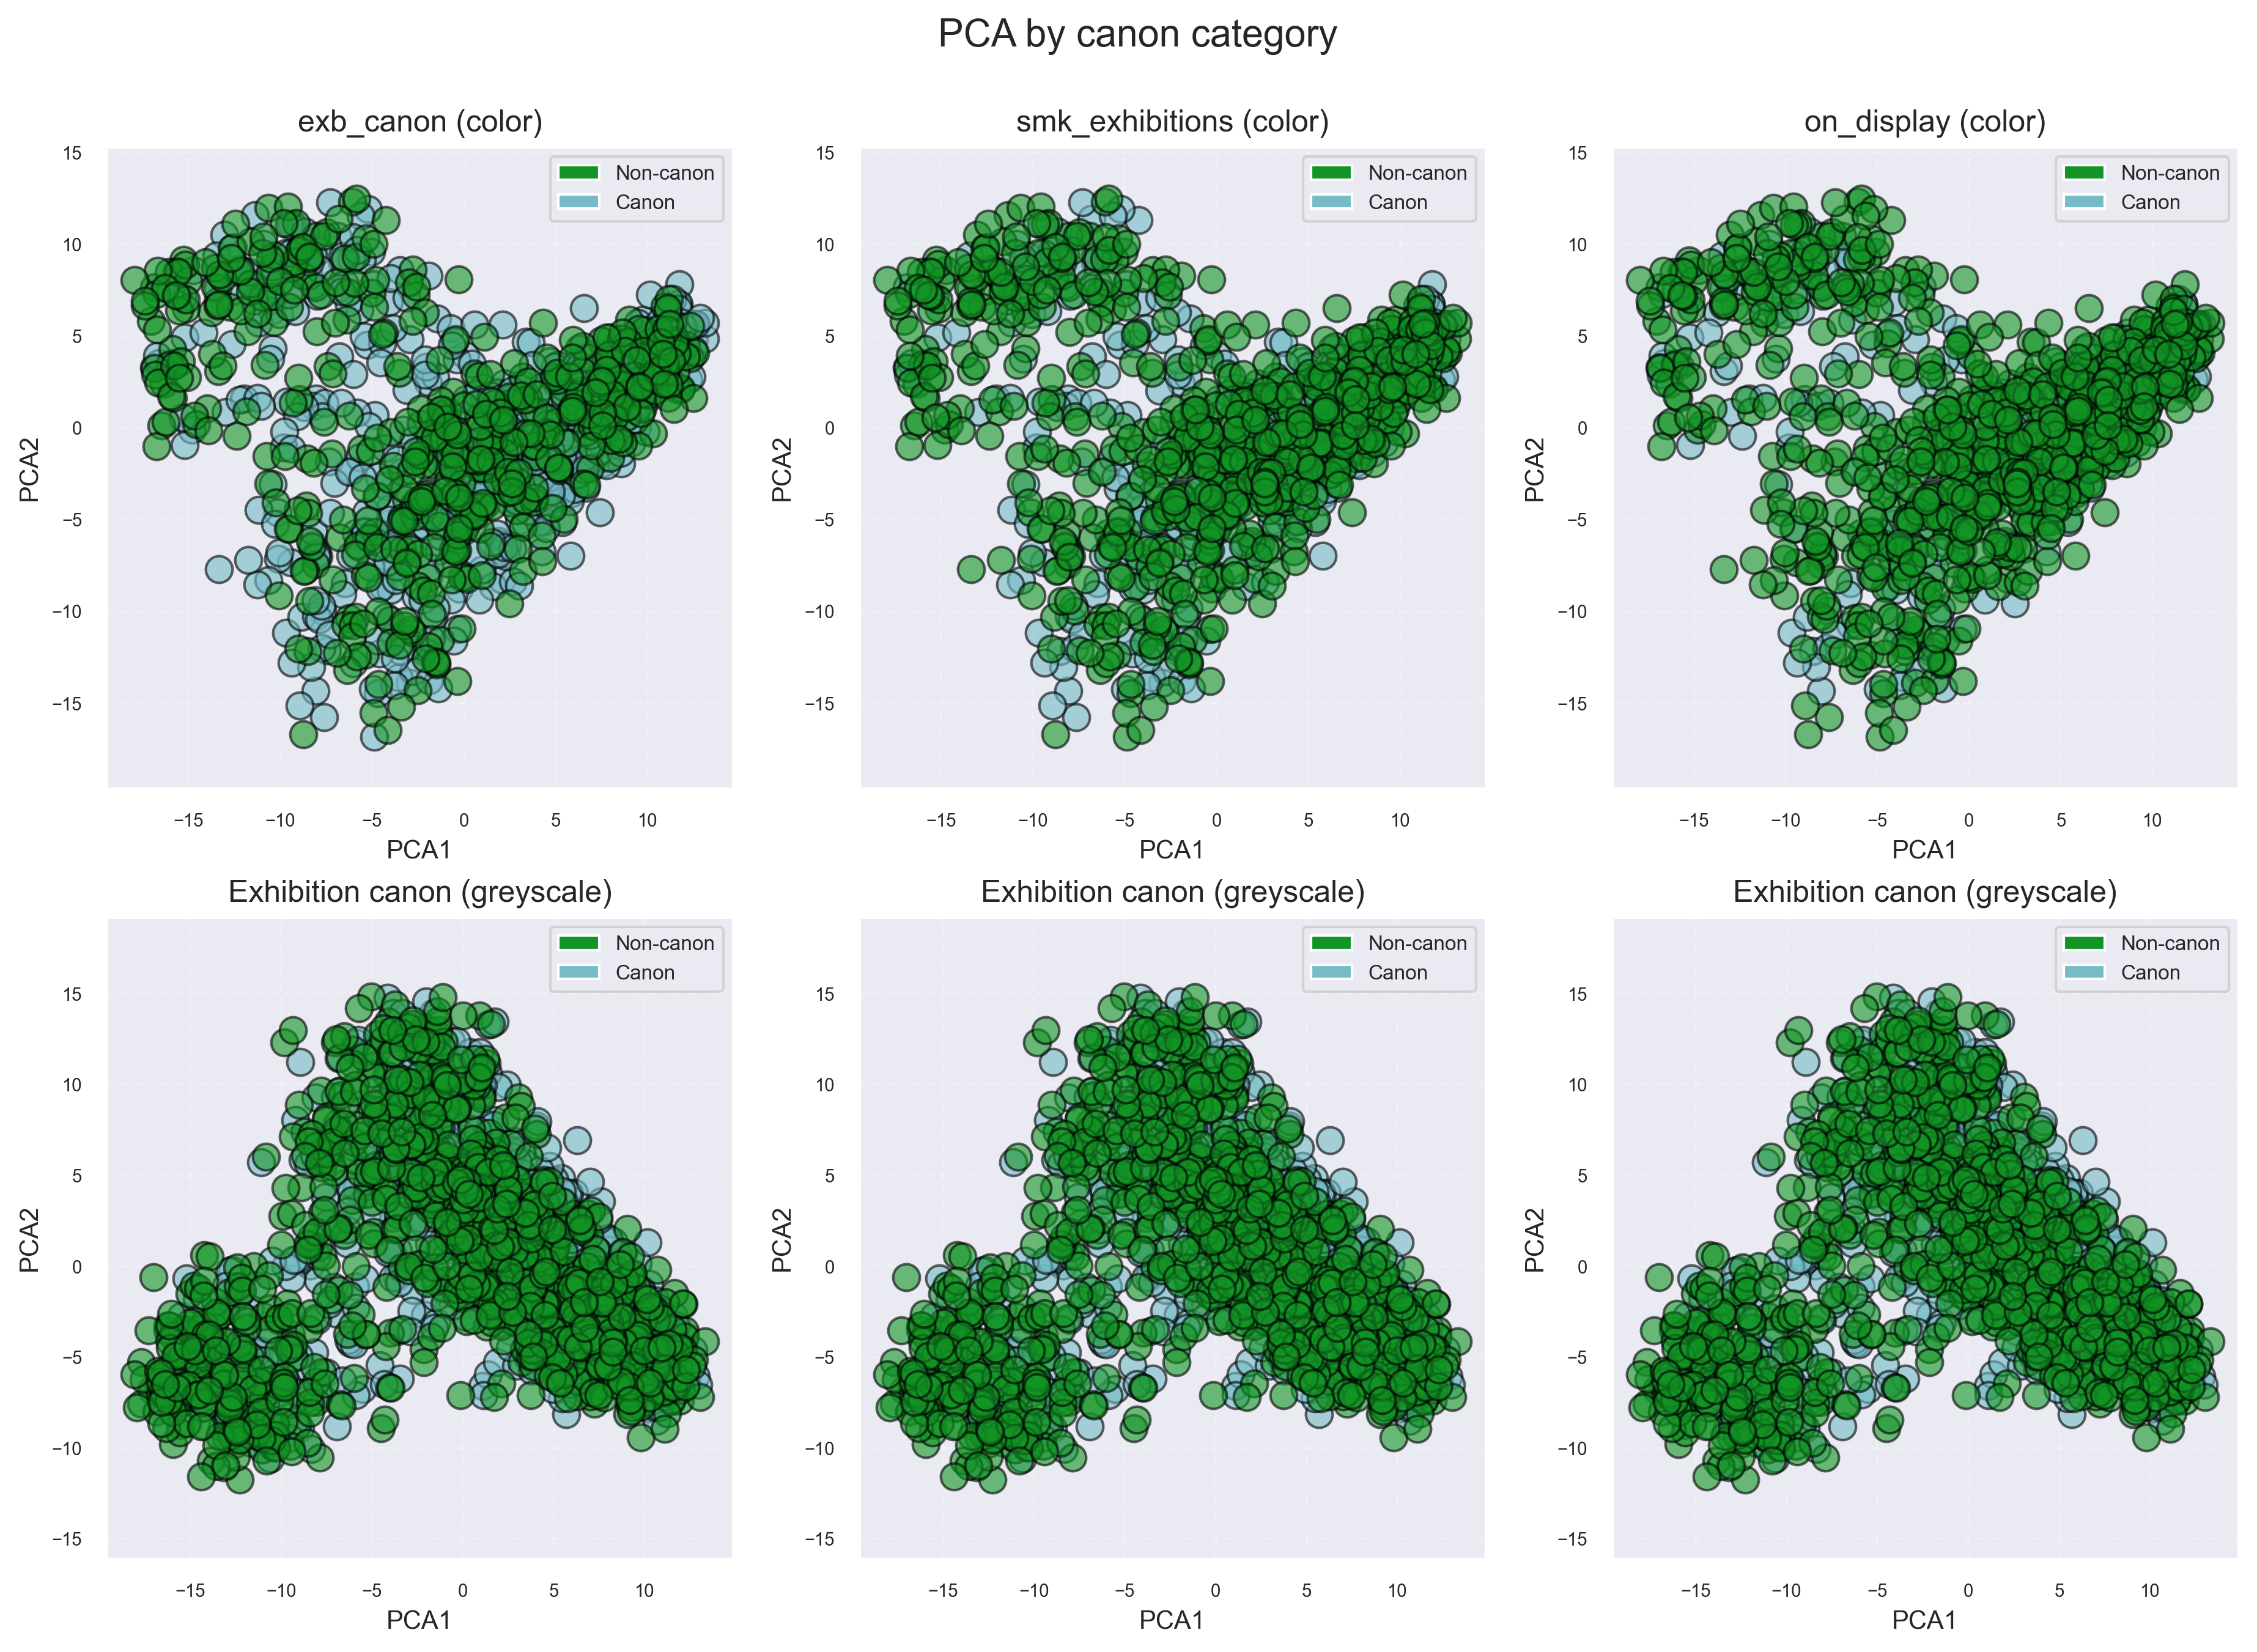

In [75]:
# PCA plots with binary canon variables
from src.analyses_utils import pca_binary
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

canon_cols = ['exb_canon', 'smk_exhibitions', 'on_display']

for idx, col in enumerate(canon_cols):

    pca_binary(ax = axs[0, idx], 
                    df = color_subset, 
                    embedding = 'embedding', 
                    canon_category = col, 
                    title = f"{col} (color)")

    pca_binary(ax = axs[1, idx], 
                    df = df, 
                    embedding = 'grey_embedding', 
                    canon_category = 'exb_canon', 
                    title = "Exhibition canon (greyscale)")

fig.suptitle('PCA by canon category', size = 15, y=0.95)

## Diachronic Change

We inspect temporal changes in embeddings through inter-group (canon vs non-canon) and intra-group (within canon-groups) with cosine similarities of embeddings:

(Code is adapted from Feldkamp et al. (2024) (https://aclanthology.org/2024.nlp4dh-1.14/))

In [77]:
from src.analyses_utils import plot_grid, plot_diachronic_change

#### Intra-group, canon

Plotting canon columns for CANON_COSIM_MEAN: 100%|██████████| 3/3 [01:02<00:00, 20.99s/it]


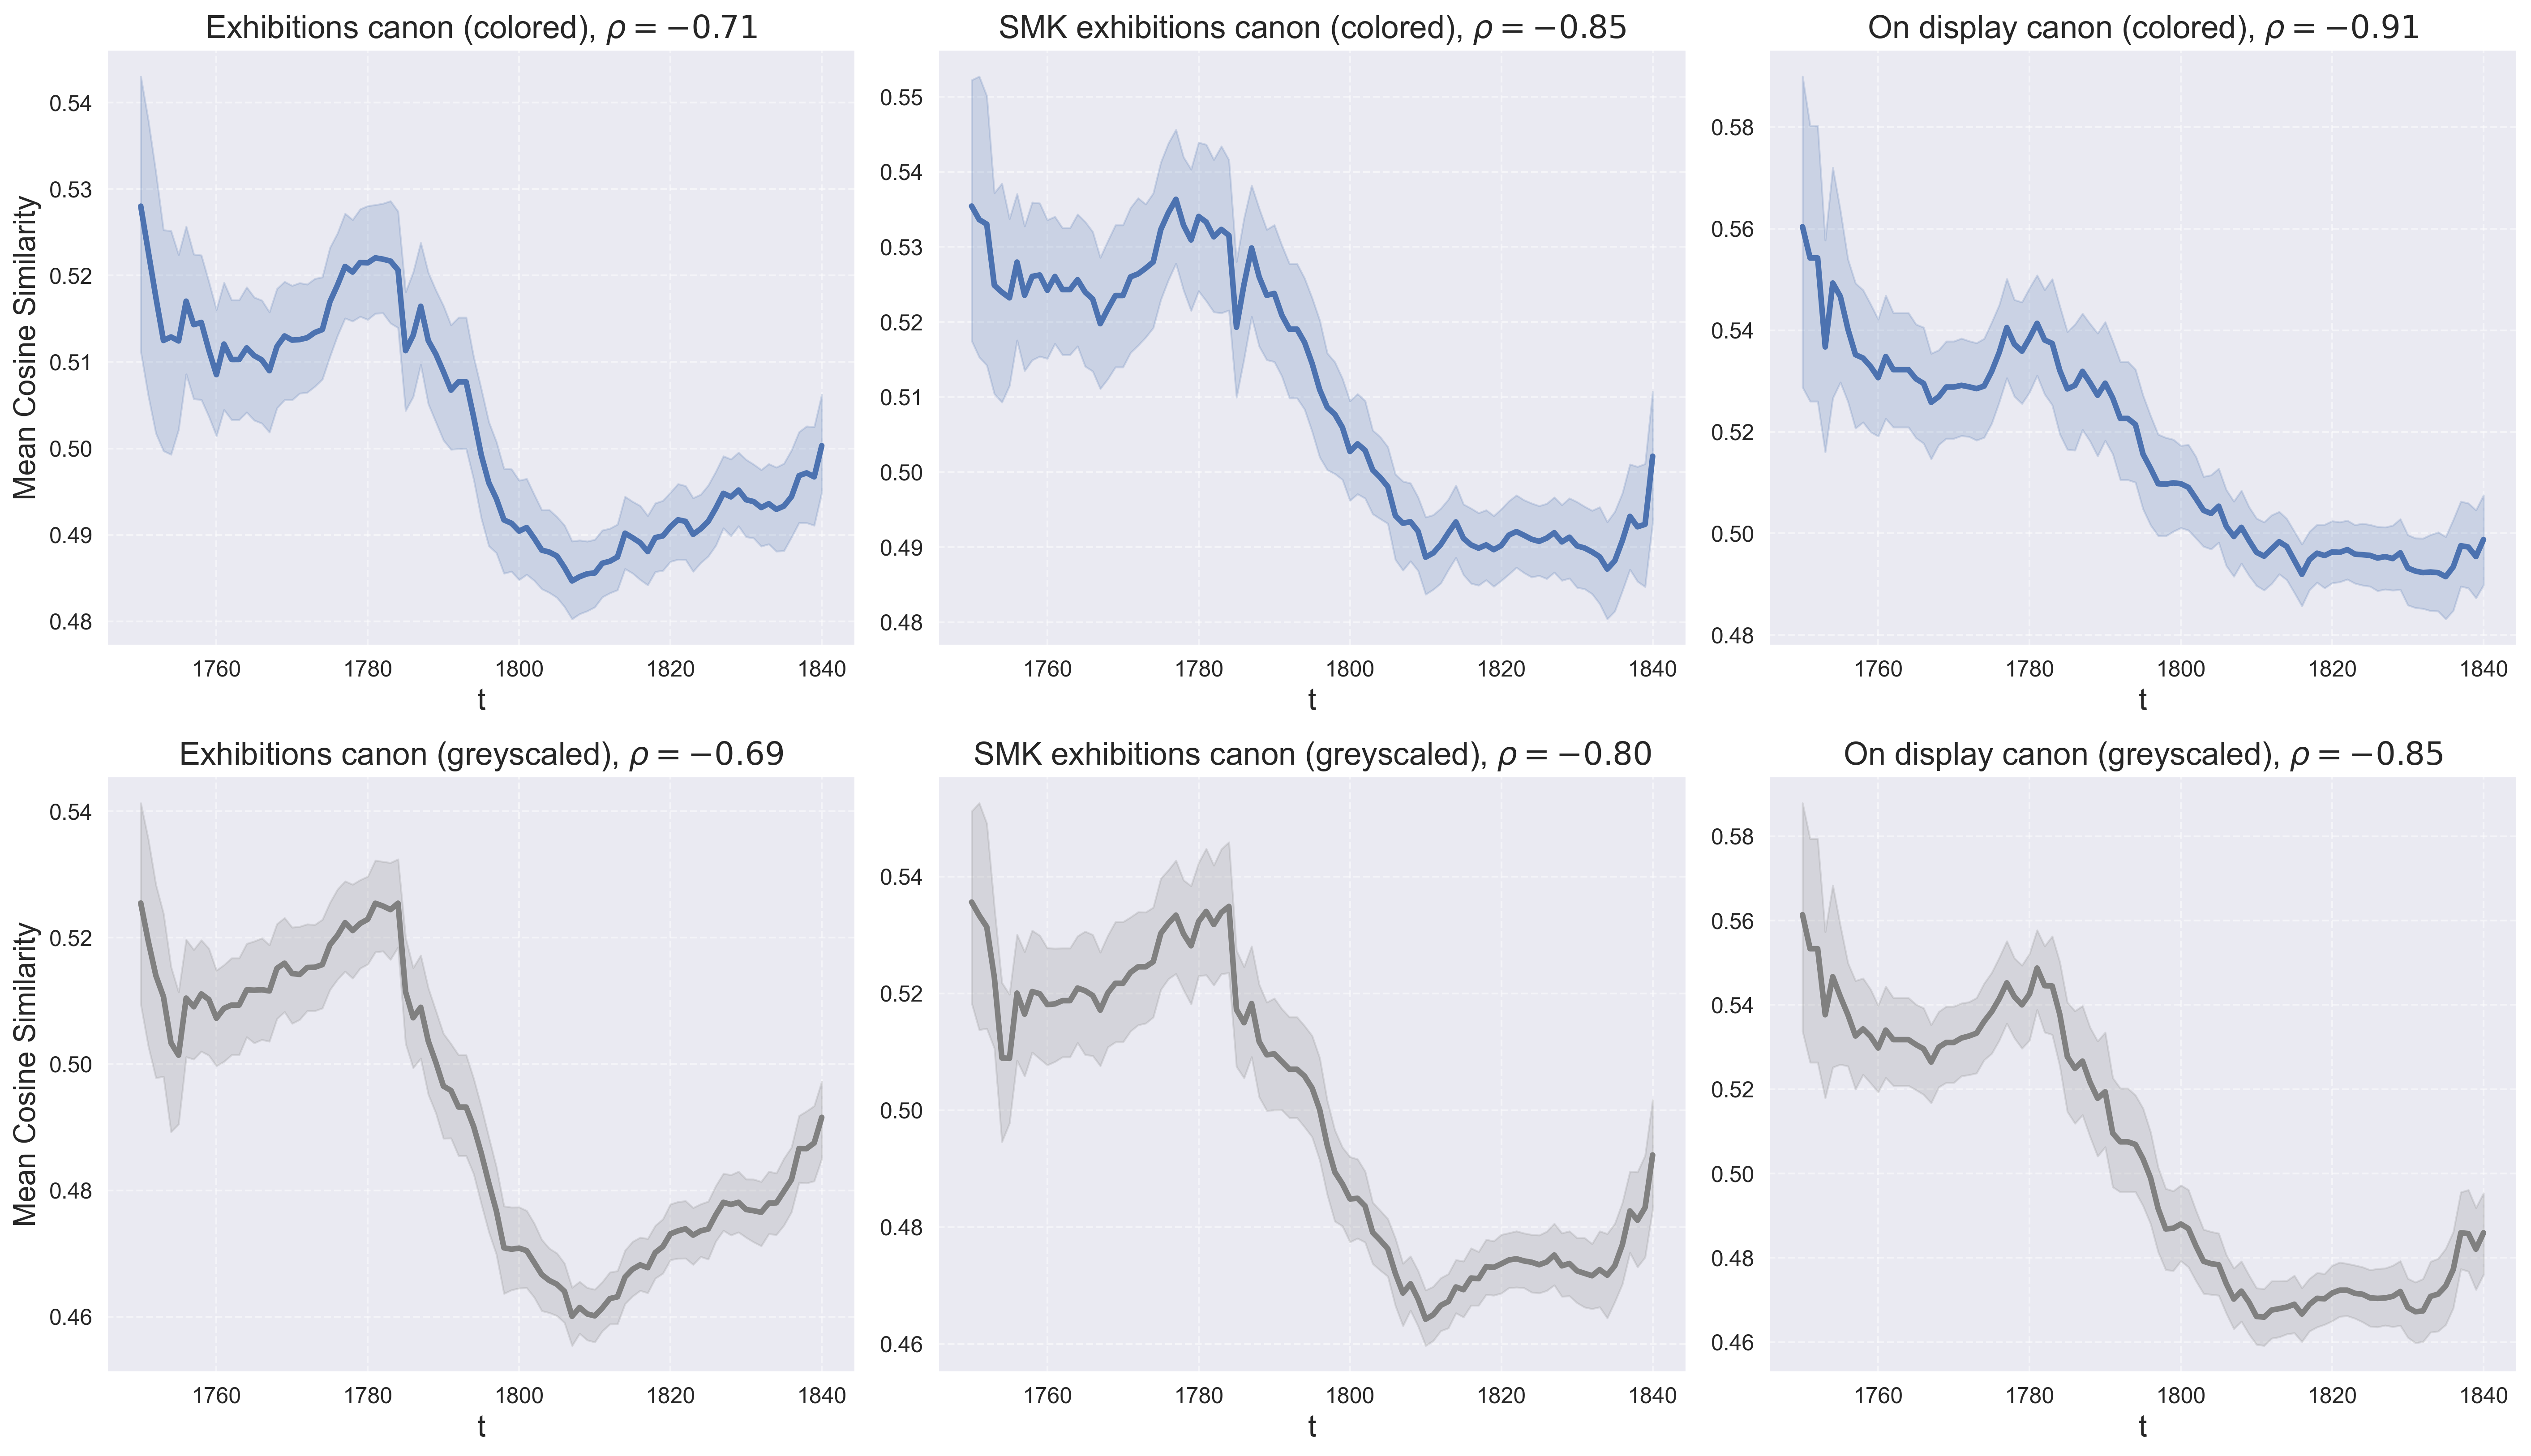

In [78]:
plot_grid(df = df,
           color_subset=color_subset, 
            canon_cols = canon_cols,
            w_size= 30, 
            cosim_to_plot='CANON_COSIM_MEAN', 
            savefig=False,
            filename='')

#### Intra-group, non-canon

Plotting canon columns for NONCANON_COSIM_MEAN: 100%|██████████| 3/3 [01:03<00:00, 21.23s/it]


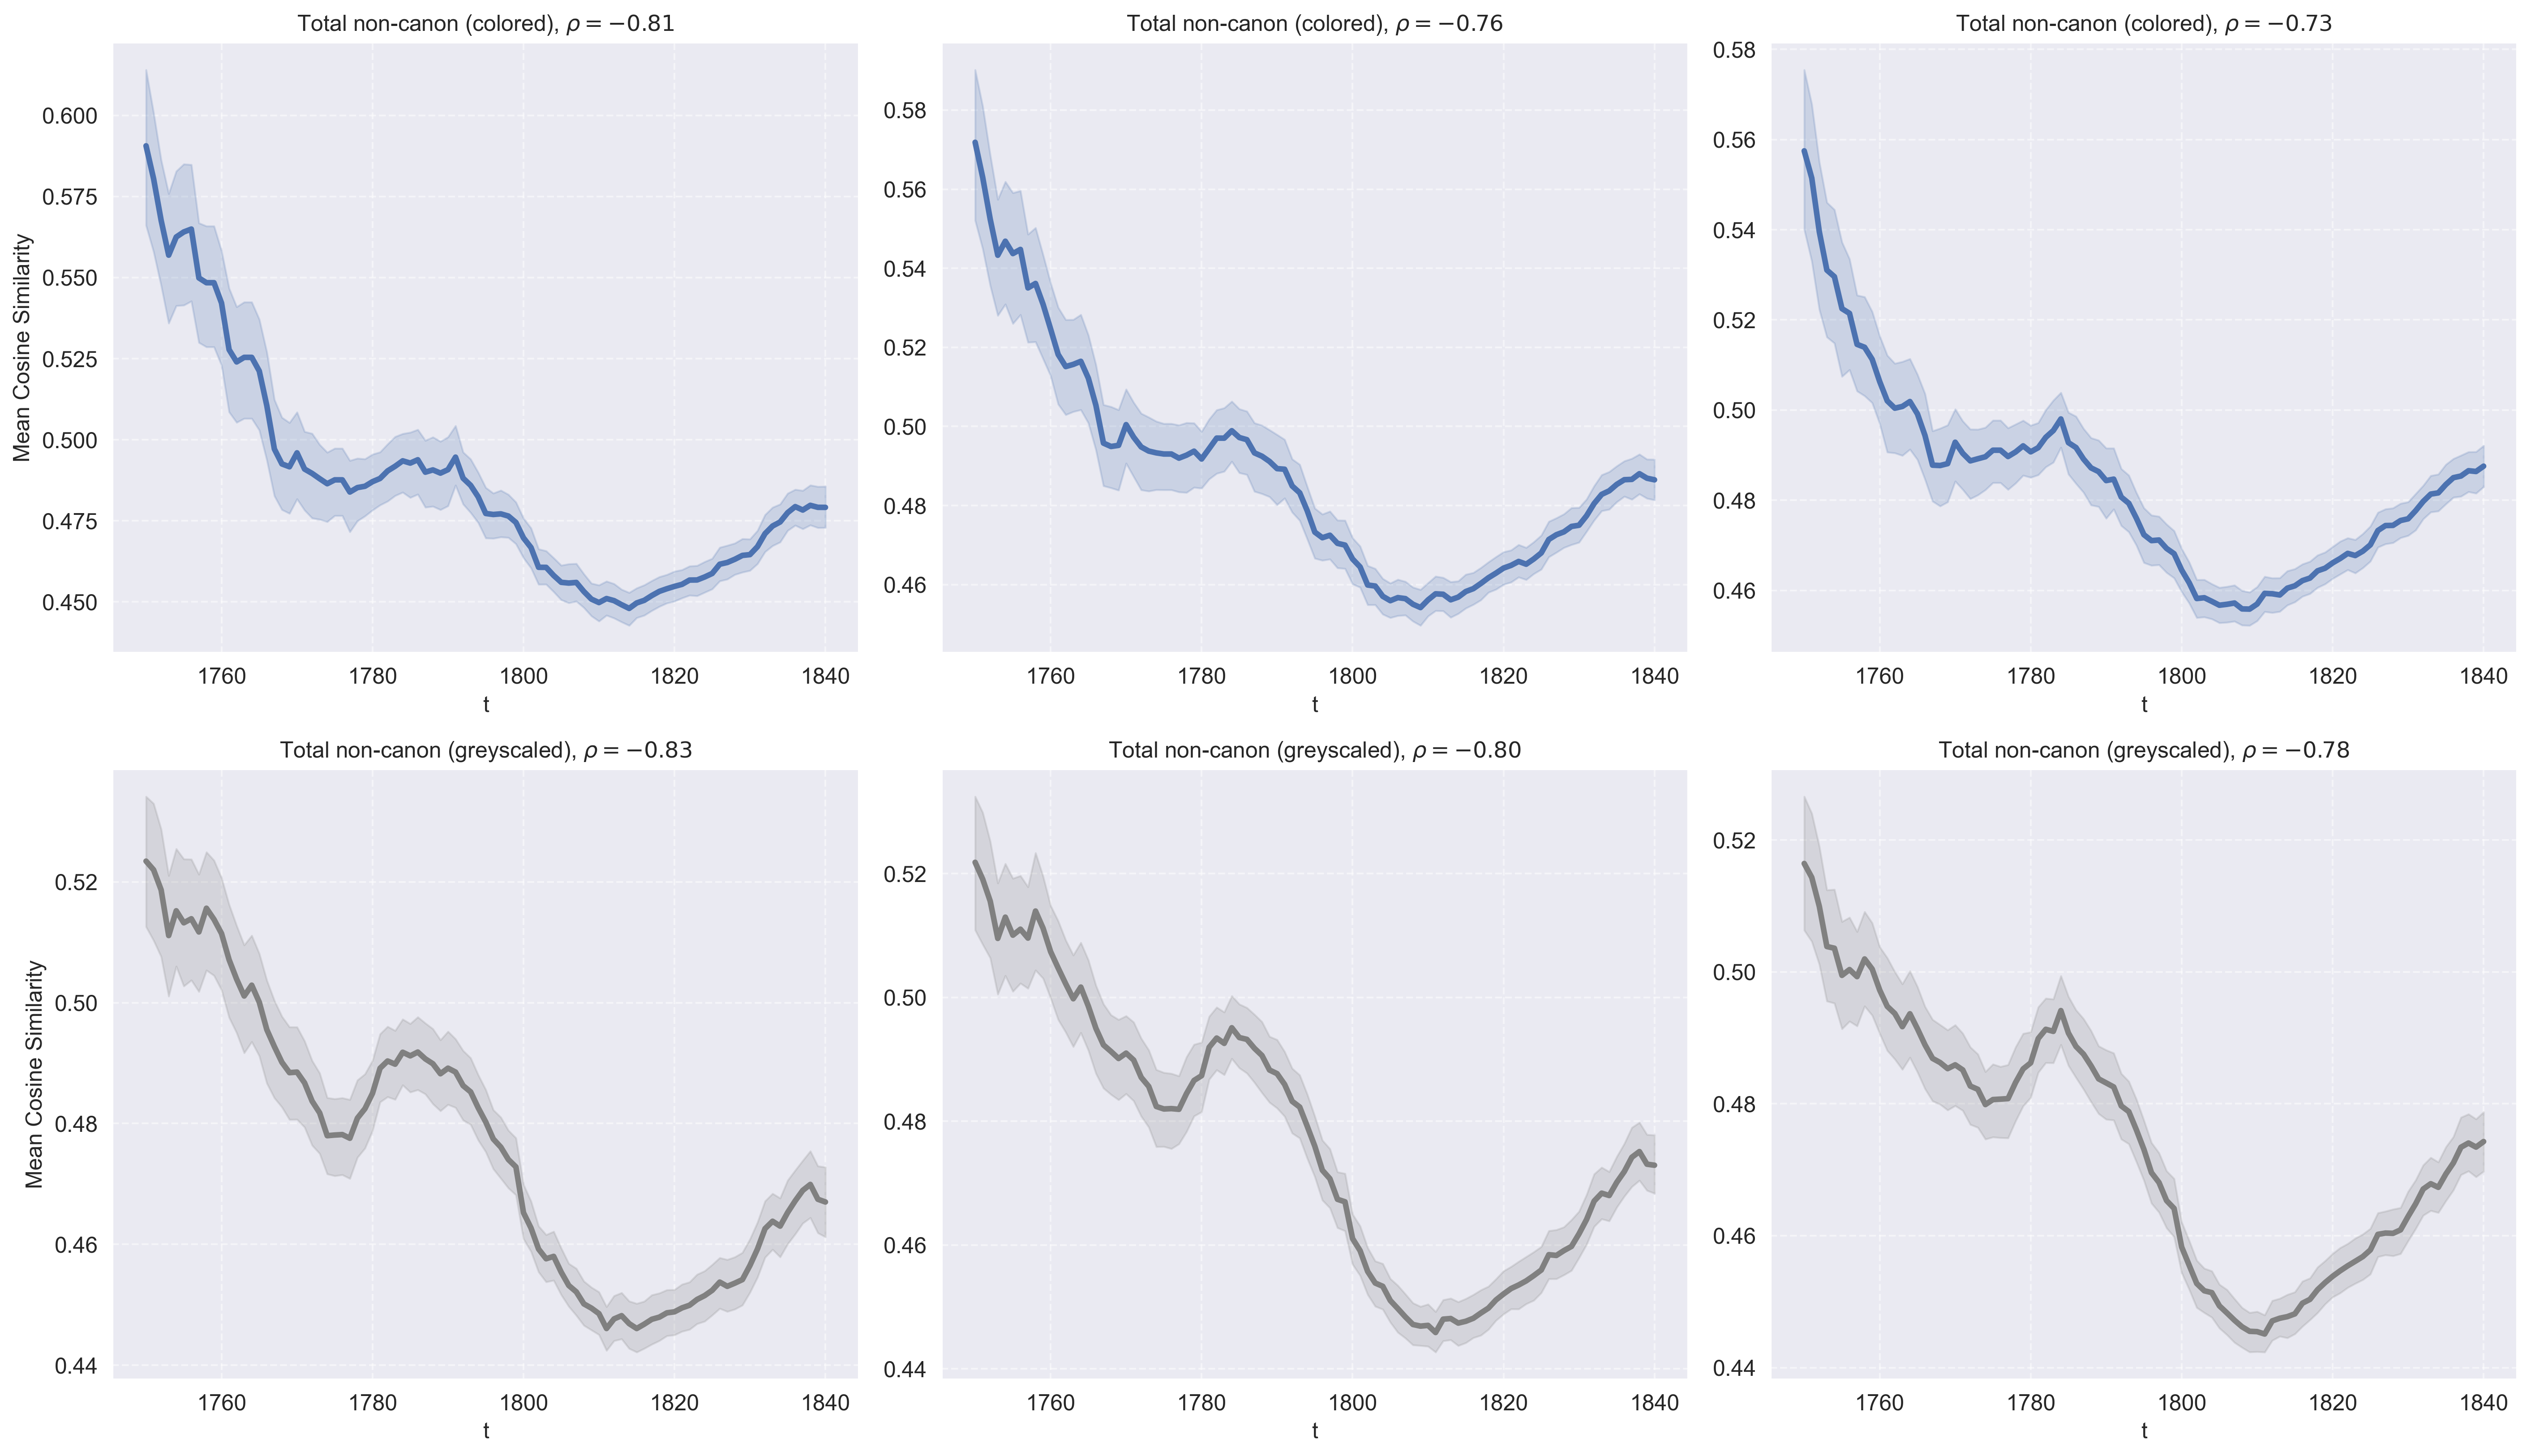

In [79]:
plot_grid(df = df, 
        color_subset = color_subset, 
        canon_cols = canon_cols,
        w_size= 30, 
        cosim_to_plot='NONCANON_COSIM_MEAN',
        savefig=False,
        filename='')

#### Intra-group, total non-canon

Text(0, 0.5, '')

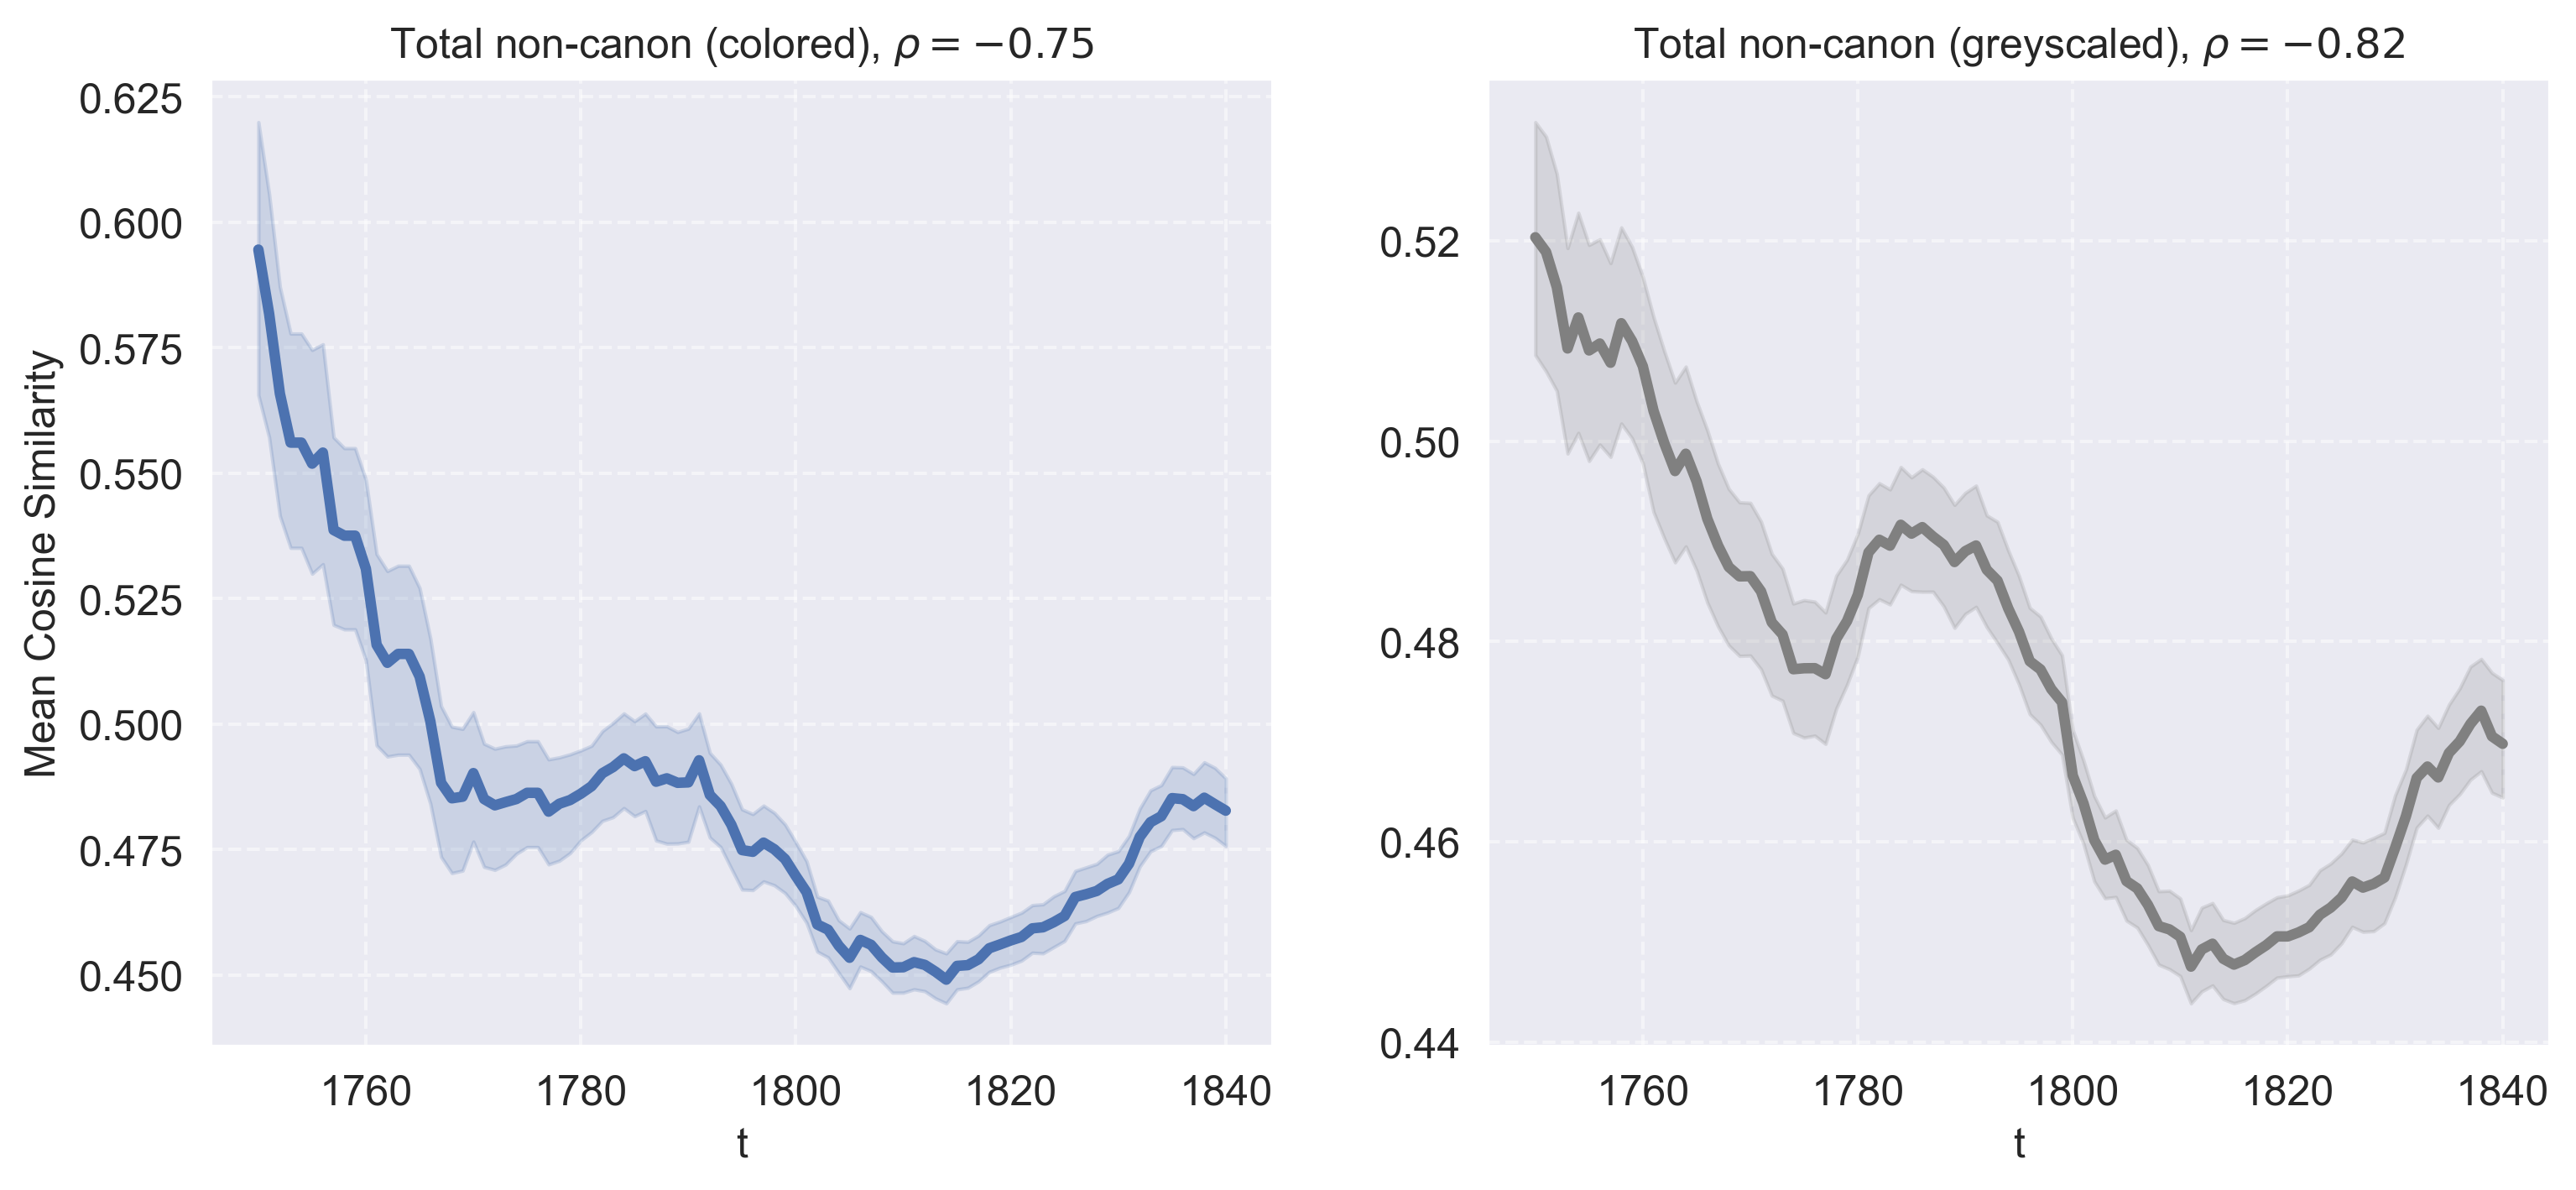

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plot_diachronic_change(w_size = 30, 
                df = color_subset, 
                canon_col = 'total_canon', 
                embedding_col = 'embedding', 
                cosim_to_plot = 'NONCANON_COSIM_MEAN', 
                ax = axs[0])

plot_diachronic_change(w_size = 30, 
               df = df, 
            canon_col = 'total_canon', 
             embedding_col = 'grey_embedding', 
             cosim_to_plot = 'NONCANON_COSIM_MEAN', 
              ax = axs[1])

    # remove y label from second plot
axs[1].set_ylabel("")

#### Inter-group

Plotting canon columns for CANON_NONCANON_COSIM: 100%|██████████| 3/3 [01:04<00:00, 21.51s/it]


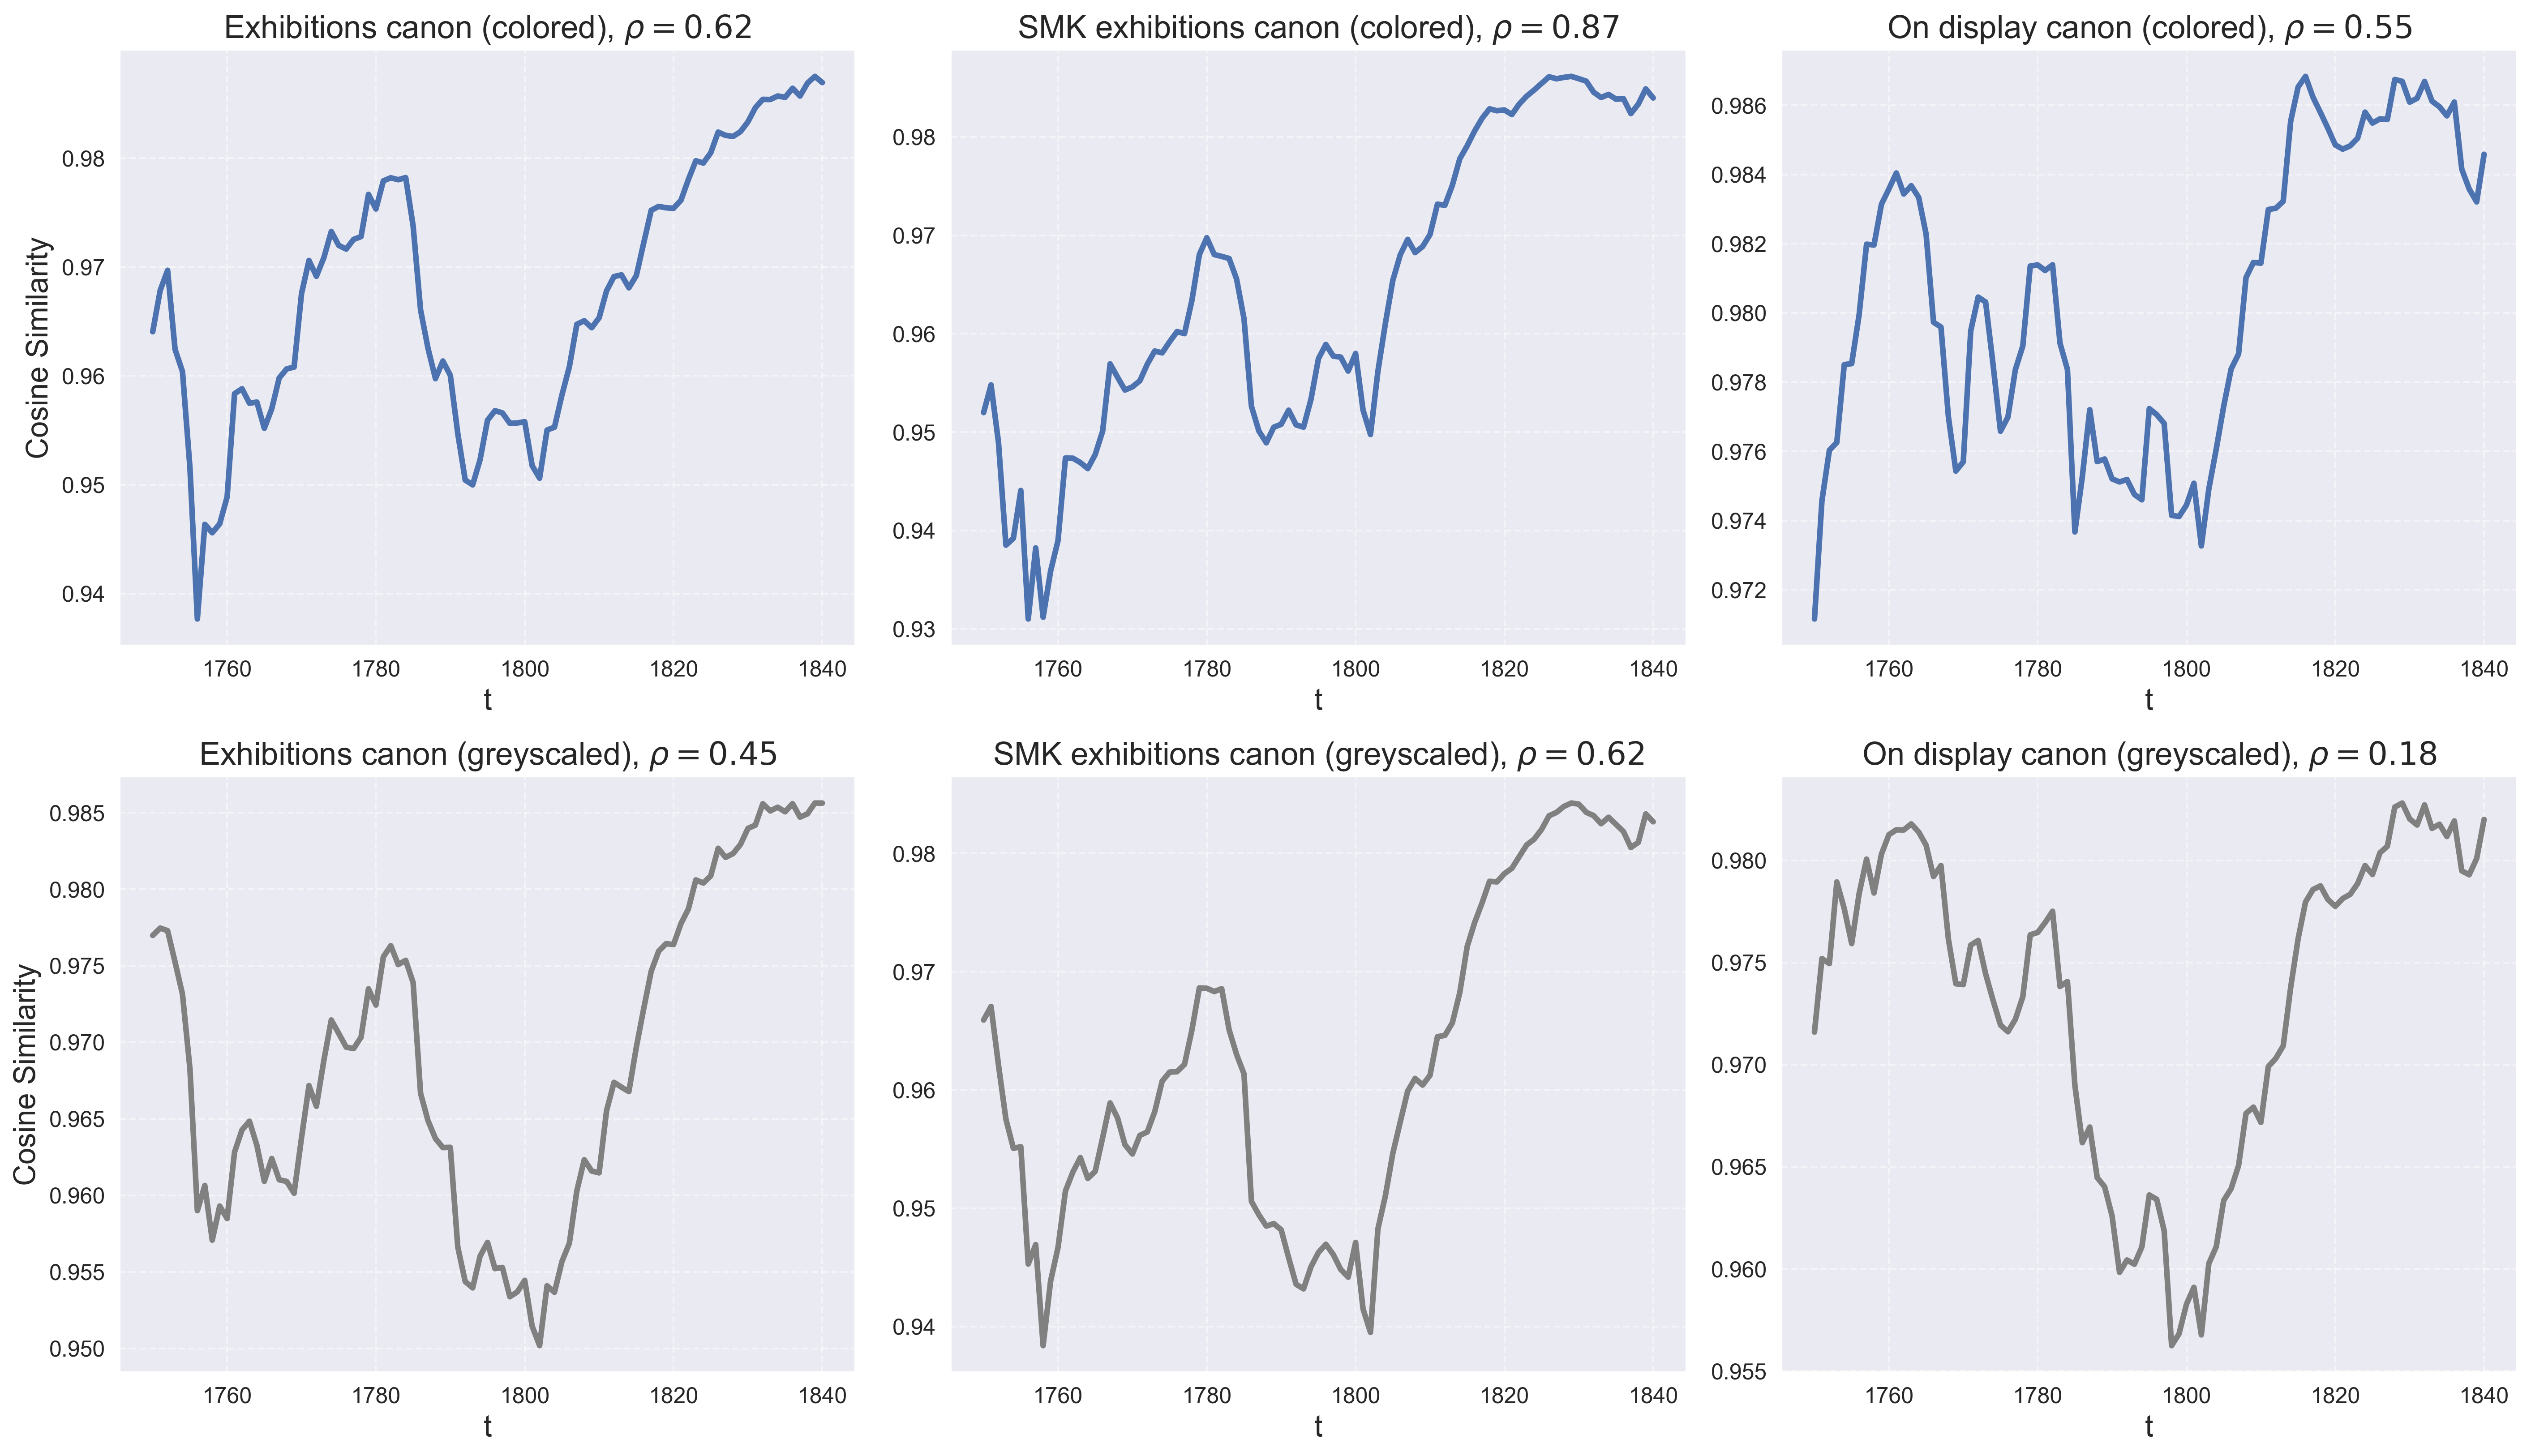

In [81]:
# inter-group
plot_grid(df = df, 
           color_subset = color_subset, 
          canon_cols = canon_cols,
         w_size= 30, 
        cosim_to_plot='CANON_NONCANON_COSIM', 
      savefig=False,
     filename='')

## Classification

The following runs two separate classification models, a Logistic Regression and MLP classifier. Both models are furthermore run with and without balancing the classes

In [82]:
from src.analyses_utils import save_classification_results

In [86]:
models = ['logistic', 'mlp'] # specify models
sampling_methods = [False, True] # do not apply / apply balancing of classes

# run for both greyscale and color data
save_classification_results(canon_cols=canon_cols, 
                                models=models, 
                                sampling_methods=sampling_methods, 
                                df=df, 
                                embedding_col='grey_embedding', 
                                col_or_grey='greyscale',
                                save_report=False)

save_classification_results(canon_cols=canon_cols, 
                                models=models, 
                                sampling_methods=sampling_methods, 
                                df=color_subset, 
                                embedding_col='embedding', 
                                col_or_grey='color',
                                save_report=False)

CLASSIFICATION RESULTS, greyscale (MEAN 10-FOLD CV MACRO F1 SCORES):
+--------+-----------------+----------------+----------------+-----------------+
|        | unbalanced_logi | balanced_logis | unbalanced_mlp |  balanced_mlp   |
|        |      stic       |      tic       |                |                 |
+--------+-----------------+----------------+----------------+-----------------+
| exb_ca | (np.float64(0.6 | (np.float64(0. | (np.float64(0. | (np.float64(0.7 |
|  non   | 81), np.float64 | 687), np.float | 699), np.float | 03), np.float64 |
|        |    (0.054))     |   64(0.051))   |   64(0.045))   |    (0.057))     |
+--------+-----------------+----------------+----------------+-----------------+
| smk_ex | (np.float64(0.6 | (np.float64(0. | (np.float64(0. | (np.float64(0.6 |
| hibiti | 58), np.float64 | 615), np.float | 667), np.float | 47), np.float64 |
|  ons   |    (0.061))     |   64(0.073))   |   64(0.064))   |    (0.068))     |
+--------+-----------------+------------